In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import tensorflow as tf
tf.__version__

'1.4.0'

In [38]:
import keras
keras.__version__

'2.1.2'

In [39]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imread

In [41]:
from random import shuffle, random
import cv2
from skimage import exposure
from tqdm import tqdm
from sklearn.utils import shuffle as shuffle_X_y
from math import pi, cos, sin, degrees, radians, atan2, sqrt

In [42]:
from preprocess import *

In [43]:
data_dir = 'data'

In [44]:
def parse_file_name(full_path):
    if '/' in full_path:
        return full_path.split('/')[-1]
    else:
        return full_path

In [45]:
def load_data(data_dir):
    colnames = ['center_img', 'left_img', 'right_img', 'steering_angle', 
                'throttle', 'break', 'speed']
    driving_log_pd = pd.read_csv('%s/driving_log.csv' % data_dir, sep=',', names=colnames)
    
    for colname in ['center_img', 'left_img', 'right_img']:
        driving_log_pd[colname] = [parse_file_name(x) for x 
                                   in driving_log_pd[colname].tolist()]
        
    return driving_log_pd

## Data Exploration

In [47]:
driving_log_pd = load_data(data_dir)

In [48]:
driving_log_pd.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,center_2018_01_22_19_22_53_312.jpg,left_2018_01_22_19_22_53_312.jpg,right_2018_01_22_19_22_53_312.jpg,0.0,0.0,0.0,5.544637
1,center_2018_01_22_19_22_53_419.jpg,left_2018_01_22_19_22_53_419.jpg,right_2018_01_22_19_22_53_419.jpg,0.0,0.0,0.0,5.489003
2,center_2018_01_22_19_22_53_517.jpg,left_2018_01_22_19_22_53_517.jpg,right_2018_01_22_19_22_53_517.jpg,0.0,0.0,0.0,5.433926
3,center_2018_01_22_19_22_53_589.jpg,left_2018_01_22_19_22_53_589.jpg,right_2018_01_22_19_22_53_589.jpg,0.0,0.0,0.0,5.390263
4,center_2018_01_22_19_22_53_690.jpg,left_2018_01_22_19_22_53_690.jpg,right_2018_01_22_19_22_53_690.jpg,0.0,0.0,0.0,5.336177


In [49]:
def display_images(X, start_idx=0, end_idx=None,  columns = 5, use_gray=False, 
                   apply_fnc=None, figsize=(32,18)):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=figsize)

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 
            
    plt.tight_layout()
            
    plt.show()

In [50]:
def read_imgs(img_dir, file_names):
    img_arr = []
    
    for file_name in file_names:
        img = imread('%s/%s' % (img_dir, file_name))
        img_arr.append(img)
        
    return np.stack(img_arr)

In [51]:
img_dir = '%s/IMG' % data_dir

In [52]:
sample_imgs = read_imgs(img_dir, driving_log_pd.iloc[:10, 0].tolist())

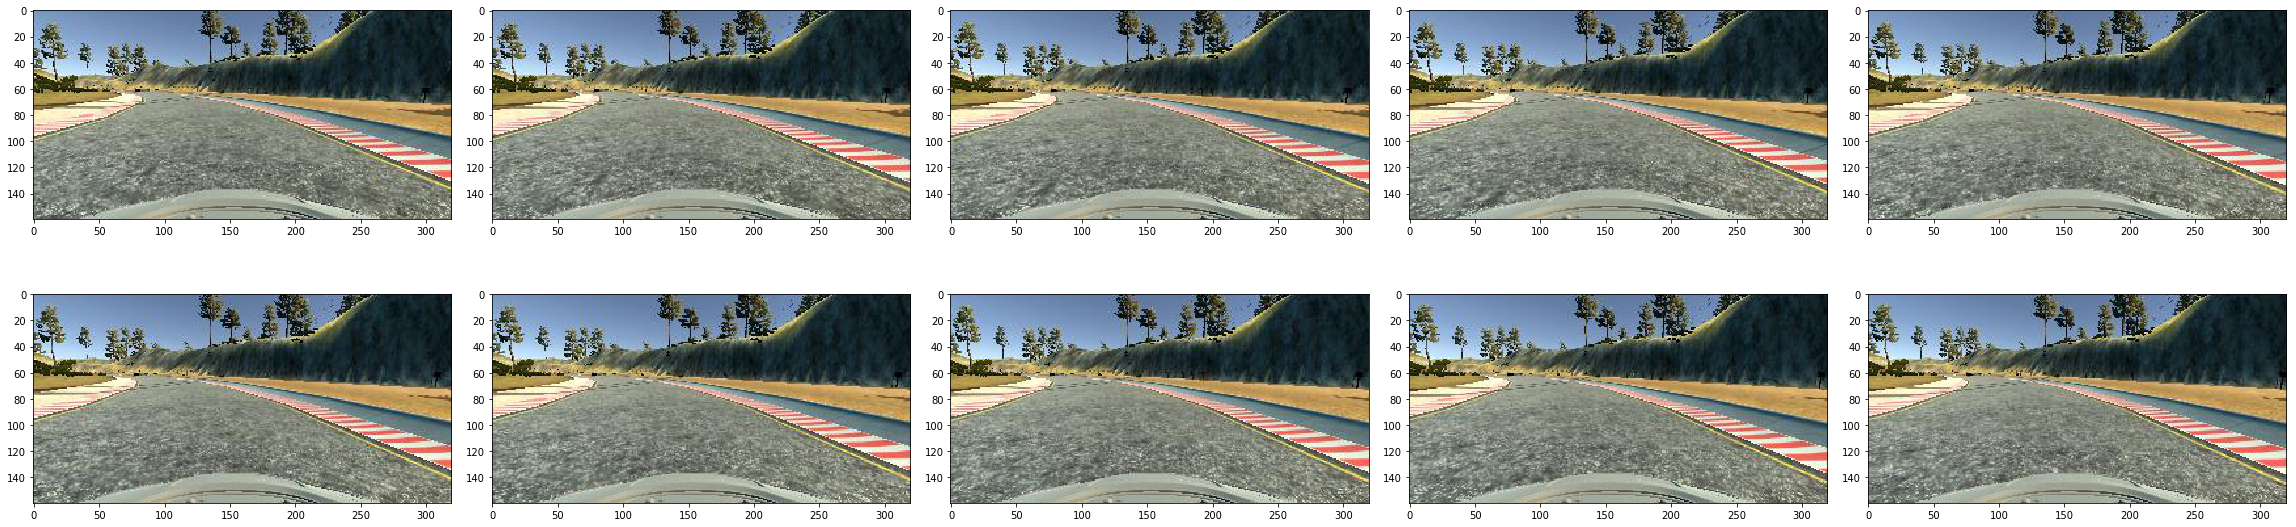

In [53]:
display_images(sample_imgs, columns=5, figsize=(32,12))

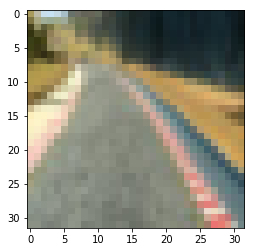

In [54]:
plt.imshow(preprocess_image(sample_imgs[0], apply_normalize=False))
plt.show()

### Steering Angles

In [55]:
steering_angles = driving_log_pd['steering_angle'].tolist()

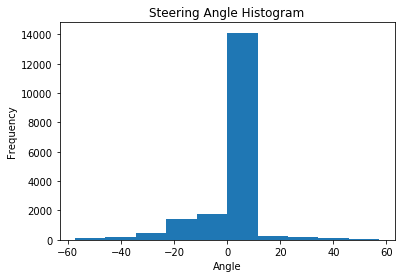

In [64]:
n, bins, patches = plt.hist([degrees(x) for x in steering_angles])
plt.title("Steering Angle Histogram")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

In [61]:
print("steering angle range: %3f-%3f" % (degrees(min(steering_angles)), degrees(max(steering_angles))))

steering angle range: -57.295780-57.295780


## Data

In [21]:
def split_train_test(img_steering_pd, train_perc=0.7, val_perc=0.2):
    idx_len = len(img_steering_pd.index)
    idxs = list(range(idx_len))
    shuffle(idxs)
    
    idx1 = int(idx_len*train_perc)
    idx2 = idx1 + int(idx_len*val_perc)
    
    train_pd = img_steering_pd.iloc[idxs[:idx1]]
    val_pd = img_steering_pd.iloc[idxs[idx1:idx2]]
    test_pd = img_steering_pd.iloc[idxs[idx2:]]
    
    return train_pd, val_pd, test_pd

In [22]:
import os

In [23]:
train_pd_file = '%s/train.p' % data_dir
val_pd_file = '%s/val.p' % data_dir
test_pd_file = '%s/test.p' % data_dir

if not os.path.exists(train_pd_file) or not os.path.exists(val_pd_file) \
    or not os.path.exists(test_pd_file):
    train_pd, val_pd, test_pd = split_train_test(driving_log_pd)
    train_pd.to_pickle(train_pd_file)
    val_pd.to_pickle(val_pd_file)
    test_pd.to_pickle(test_pd_file)
else:
    train_pd = pd.read_pickle(train_pd_file)
    val_pd = pd.read_pickle(val_pd_file)
    test_pd = pd.read_pickle(test_pd_file)    

### Preprocessing Images

The images will be preprocessed with the following steps:
1. Crop
    * The top and bottom of the images will be cropped to reduce the size of the input.
2. Normalization
    * The images are normalized with a range of -0.5 to 0.5.

In [24]:
X_train_files = train_pd['center_img'].tolist()
y_train = np.array(train_pd['steering_angle'])

In [25]:
X_val = preprocess_images(read_imgs(img_dir, val_pd['center_img'].tolist()), x0=0, y0=48, x1=None, y1=112)
y_val = np.array(val_pd['steering_angle'])
X_test = preprocess_images(read_imgs(img_dir, test_pd['center_img'].tolist()), x0=0, y0=48, x1=None, y1=112)
y_test = np.array(test_pd['steering_angle'])

## Model

In [26]:
def make_model(input_shape = (64, 320, 3), p = 0.5):
    model = Sequential()

    # block 1
    model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # block 2
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # block 3
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
          
    model.add(Flatten())          
 
    model.add(Dense(64, activation=None))
    model.add(Dropout(p))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    return model

In [27]:
def image_gen(X_files, y, batch_size, img_dir, y0=48, y1=112): 
    X_len = len(X_files)
    idxs = list(range(X_len))
    
    while True:
        shuffle(idxs)
        y = y[idxs]
        X_files = [X_files[i] for i in idxs]
        
        for i in range(0, X_len, batch_size):
            end_idx = i+batch_size
            
            if end_idx > X_len:
                continue   
  
            curr_y = y[i:end_idx]
            curr_X_files = X_files[i:end_idx]
            curr_X = read_imgs(img_dir, curr_X_files)
            
            curr_X = preprocess_images(curr_X, y0=y0, y1=y1)

            yield curr_X, curr_y

## Train Model (primary data)

In [28]:
def train_model(model, X_train_files, y_train, img_dir, X_val, y_val, 
                batch_size=32, lr=0.0001, epochs=10, workers=1):
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

    train_gen = image_gen(X_train_files, y_train, batch_size, img_dir)

    steps_per_epoch = int(len(X_train_files)/batch_size)
    model.fit_generator(train_gen, validation_data=(X_val, y_val), 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, workers=workers)   
    
    return model

In [ ]:
workers=6

In [29]:
model = make_model(input_shape = (64, 320, 3), p = 0.5)

In [30]:
model_graph_file = '%s/model.png' % data_dir
plot_model(model, to_file=model_graph_file)

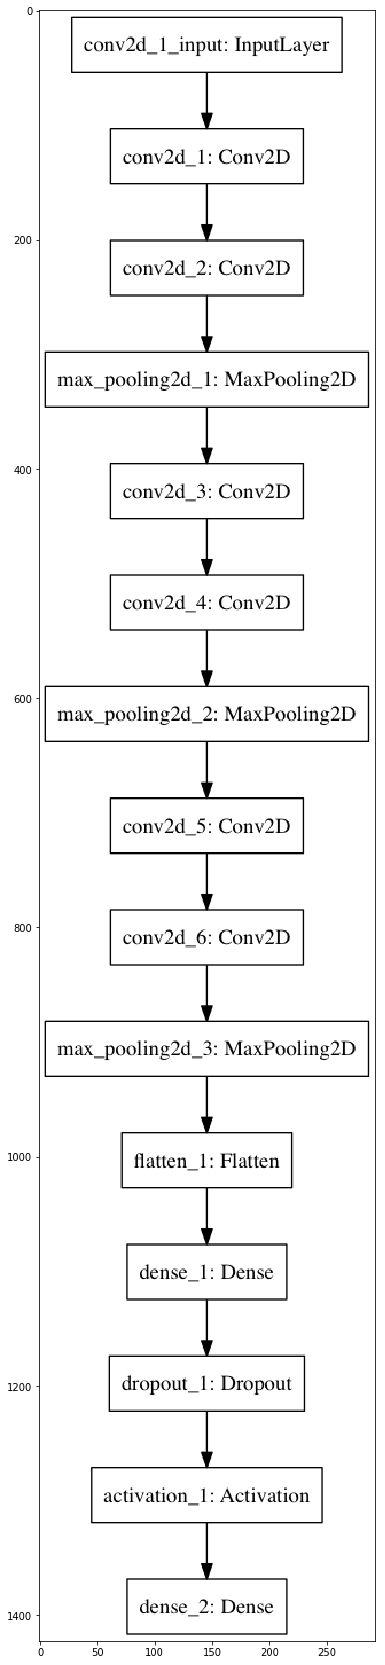

In [35]:
model_graph_img = imread(model_graph_file)

plt.figure(figsize=(50, 30))
plt.imshow(model_graph_img)
plt.show()

In [34]:
batch_size = 32

model = train_model(model, X_train_files, y_train, img_dir, X_val, y_val, workers=workers)

Epoch 1/10
407/407 [==============================] - 91s 223ms/step - loss: 0.0275 - val_loss: 0.0248
Epoch 2/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 3/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 4/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 5/10
407/407 [==============================] - 48s 117ms/step - loss: 0.0234 - val_loss: 0.0237
Epoch 6/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0230 - val_loss: 0.0234
Epoch 7/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0226 - val_loss: 0.0235
Epoch 8/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0221 - val_loss: 0.0235
Epoch 9/10
407/407 [==============================] - 47s 117ms/step - loss: 0.0218 - val_loss: 0.0234
Epoch 10/10
407/407 [==============================] - 48s 117ms/step - l

In [35]:
test_loss = model.evaluate(X_test, y_test)
print("test loss: %3f" % test_loss)

1866/1866 [==============================] - 2s 1ms/step
test loss: 0.021728


In [36]:
model.save('%s/model.h5'%data_dir)

## Fine tune model with extra data

The first model has problems right after the bridge.  It doesn't bank left hard enough and it ends up driving off the road. Train the model with extra data from just that section of the track. The learning rate of 0.0001 will be used, same as the first model.  All of the extra data will be used for training. The validation data from the first model will be reused.

In [37]:
def fine_tune_model_train(fine_tune_data_dir, model_file, X_val, y_val,
                           lr=0.0001, batch_size= 32, epochs=10, workers=1):
    # data
    train_pd = load_data(fine_tune_data_dir)
    fine_tune_img_dir = '%s/IMG' % fine_tune_data_dir
    
    X_train_files = train_pd['center_img'].tolist()
    y_train = np.array(train_pd['steering_angle'])
    train_gen = image_gen(X_train_files, y_train, batch_size, fine_tune_img_dir)
    
    # model
    model = load_model(model_file)
    
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

    steps_per_epoch = int(len(X_train_files)/batch_size)
    model.fit_generator(train_gen, validation_data=(X_val, y_val), 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, workers=workers)
    
    return model

In [38]:
extra_data_dir = 'data/data_extra'

In [41]:
model_file = '%s/model.h5' % data_dir
model2 = fine_tune_model_train(extra_data_dir, model_file, X_val, y_val, workers=workers)

Epoch 1/10
19/19 [==============================] - 6s 338ms/step - loss: 0.0356 - val_loss: 0.0244
Epoch 2/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0331 - val_loss: 0.0245
Epoch 3/10
19/19 [==============================] - 6s 317ms/step - loss: 0.0326 - val_loss: 0.0245
Epoch 4/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0293 - val_loss: 0.0248
Epoch 5/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0305 - val_loss: 0.0252
Epoch 6/10
19/19 [==============================] - 6s 317ms/step - loss: 0.0293 - val_loss: 0.0252
Epoch 7/10
19/19 [==============================] - 6s 319ms/step - loss: 0.0293 - val_loss: 0.0256
Epoch 8/10
19/19 [==============================] - 6s 319ms/step - loss: 0.0261 - val_loss: 0.0256
Epoch 9/10
19/19 [==============================] - 6s 320ms/step - loss: 0.0270 - val_loss: 0.0256
Epoch 10/10
19/19 [==============================] - 6s 320ms/step - loss: 0.0228 - val_loss: 0.0262

In [42]:
test_loss2 = model2.evaluate(X_test, y_test)
print("test loss: %3f" % test_loss)

1866/1866 [==============================] - 2s 1ms/step
test loss: 0.021728


In [43]:
model2_file = '%s/model.h5' % extra_data_dir
model2.save(model2_file)